In [1]:
import os
import json

from transformers import PatchTSTConfig, PatchTSTModel
from transformers import PatchTSTForPretraining, PatchTSTForPrediction, PatchTSTForRegression
from transformers import InformerConfig, InformerModel
# from transformers import InformerForRegression

from skllm.config import SKLLMConfig
from skllm.models.gpt.classification.zero_shot import ZeroShotGPTClassifier, MultiLabelZeroShotGPTClassifier
from skllm.models.gpt.classification.few_shot import FewShotGPTClassifier, MultiLabelFewShotGPTClassifier
from skllm.models.gpt.classification.few_shot import DynamicFewShotGPTClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn import linear_model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.svm import NuSVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

import xgboost as xgb

from datetime import datetime
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import scipy.sparse as sp

import torch as th
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

import pickle

from torch_geometric.data import Data
from torch_geometric_temporal.nn import STConv, TemporalConv, DCRNN, TGCN, GCLSTM
from dgl.nn import SAGEConv, GATConv, ChebConv, SGConv, PNAConv, GMMConv, TAGConv
import networkx as nx

from matplotlib import pyplot as plt
import seaborn as sns

import warnings

from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.torch.model.patch_tst import PatchTSTEstimator
from gluonts.torch.model.d_linear import DLinearEstimator
from gluonts.torch.model.tft import TemporalFusionTransformerEstimator
from gluonts.dataset.field_names import FieldName

from gluonts.evaluation import Evaluator

from finch import FINCH



warnings.filterwarnings('ignore')
SKLLMConfig.set_openai_key(os.environ["OPENAI_API_KEY"])

np.random.seed(1024)
th.manual_seed(1024)

/home/etienne/finch.py:13: UserWarning: pyflann not installed: No module named 'index'
  warnings.warn('pyflann not installed: {}'.format(e))


In [2]:
def load_data(path_to_data=None):
    file = open(path_to_data, 'rb')
    dico = pickle.load(file)
    patterns = dico['patterns']
    evolving_graphs = dico['evolving graphs']
    nbre_steps = dico['nbre_steps']
    data = dico['data']
    return patterns, evolving_graphs, nbre_steps, data

In [3]:
root= '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/rock/'
filenames = [fi for fi in os.listdir(root)]
filenames
# patterns, evolving_graphs, nbre_steps, data = load_data(path_to_data)
# len(patterns), nbre_steps

['rock_data142_121.pkl',
 'rock_data142_141.pkl',
 'rock_data189_124.pkl',
 'rock_data284_222.pkl',
 'rock_data113_66.pkl',
 'rock_data189_144.pkl',
 'rock_data113_106.pkl',
 'rock_data284_162.pkl',
 'rock_data189_94.pkl',
 'rock_data142_131.pkl',
 'rock_data284_142.pkl',
 'rock_data284_182.pkl',
 'rock_data113_76.pkl',
 'rock_data189_184.pkl',
 'rock_data142_101.pkl',
 'rock_data284_202.pkl',
 'rock_data284_262.pkl',
 'rock_data142_81.pkl',
 'rock_data284_252.pkl',
 'rock_data284_272.pkl',
 'rock_data189_154.pkl',
 'rock_data113_96.pkl',
 'rock_data284_152.pkl',
 'rock_data284_232.pkl',
 'rock_data142_71.pkl',
 'rock_data284_172.pkl',
 'rock_data284_212.pkl',
 'rock_data189_174.pkl',
 'rock_data189_104.pkl',
 'rock_data142_91.pkl',
 'rock_data189_164.pkl',
 'rock_data113_86.pkl',
 'rock_data142_111.pkl',
 'rock_data189_114.pkl',
 'rock_data284_192.pkl',
 'rock_data189_134.pkl',
 'rock_data284_282.pkl',
 'rock_data284_242.pkl',
 'rock_data113_56.pkl']

In [5]:
res = {}
res['stride'] = []
res['patterns'] = []
res['window'] = []
for fi in filenames:
    patterns, evolving_graphs, nbre_steps, data = load_data(root+fi)
    res['stride'].append(int(fi.split('.')[0].split('_')[-1]))
    res['patterns'].append(len(patterns))
    res['window'].append(int(fi.split('_')[1].replace('data','')))

res = pd.DataFrame(res)
res.sort_values(by=['patterns'], inplace=True)

In [12]:
len(res)

39

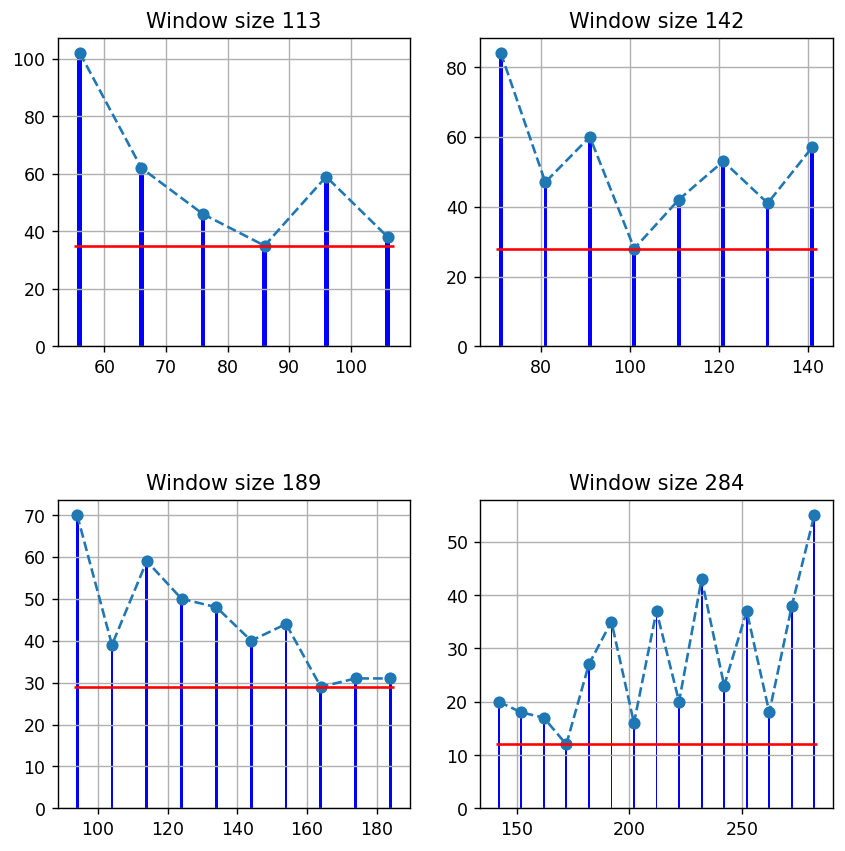

In [20]:
fig = plt.figure(figsize=(8,8), dpi=125)
i = 1
cols = 2
row = len(res.window.unique())
for window in sorted(res.window.unique()):
    ax = fig.add_subplot(row//cols, cols, i)
    case = res[res.window==window]
    case.sort_values(by='stride', inplace=True)
    # case.plot.bar(x='stride',y='patterns',ax=ax)
    ax.plot(case.stride.values, case.patterns.values,'o--')
    ax.hlines(y=min(case.patterns.values),color='r',xmin=min(case.stride.values)-1,xmax=max(case.stride.values)+1)
    # ax.scatter(case.stride.values, case.patterns.values)
    ax.bar(case.stride.values, case.patterns.values,color='blue')
    ax.grid(True)
    ax.set_title('Window size '+str(window))
    i += 1
plt.subplots_adjust(hspace=.5)
plt.show()

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

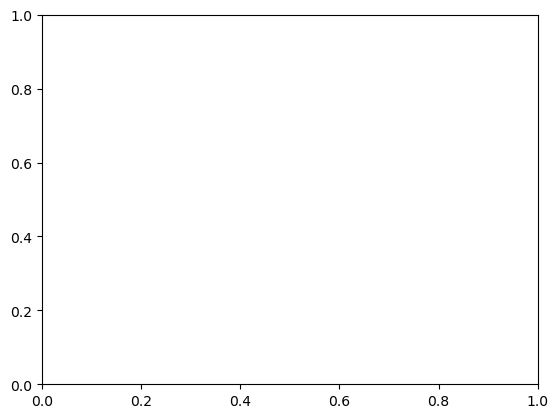

In [33]:

for w in res.window.unique():
    subres = res[res.window==w]
    sub